<a href="https://colab.research.google.com/github/nabilasah/ML-/blob/main/Aufgabe9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100:
Train Loss: 581.933 | Train Accuracy: 45.08%
Test Loss: 146.171 | Test Accuracy: 52.37%

Epoch 2/100:
Train Loss: 388.925 | Train Accuracy: 64.55%
Test Loss: 117.896 | Test Accuracy: 60.47%

Epoch 3/100:
Train Loss: 308.332 | Train Accuracy: 72.26%
Test Loss: 97.342 | Test Accuracy: 68.21%

Epoch 4/100:
Train Loss: 259.843 | Train Accuracy: 77.10%
Test Loss: 80.701 | Test Accuracy: 73.89%

Epoch 5/100:
Train Loss: 230.300 | Train Accuracy: 79.81%
Test Loss: 82.737 | Test Accuracy: 72.70%

Epoch 6/100:
Train Loss: 208.578 | Train Accuracy: 81.42%
Test Loss: 87.165 | Test Accuracy: 71.81%

Epoch 7/100:
Train Loss: 190.195 | Train Accuracy: 83.21%
Test Loss: 58.360 | Test Accuracy: 80.74%

Epoch 8/100:
Train Loss: 176.465 | Train Accuracy: 84.48%
Test Loss: 59.003 | Test Accuracy: 80.24%

Epoch 9/100:
Train Loss: 163.634 | Train Accuracy: 85.43%
Test Loss: 56.417 | Test Accuracy: 80.58%

Epoch 10/100:

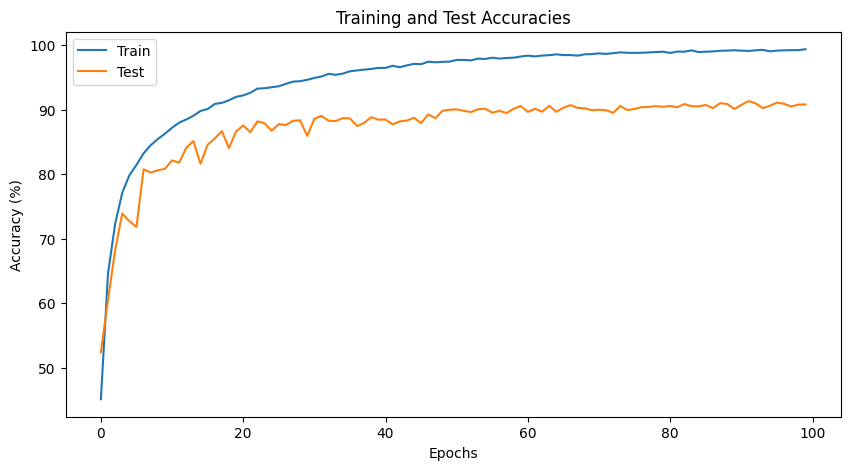

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR10 Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Define the Wide ResNet Model
class WideResNet(nn.Module):
    def __init__(self, block, num_blocks, k=2, num_classes=10):
        super(WideResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2, bias=False)
        self.layer1 = self._make_layer(block, 16*k, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32*k, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64*k, num_blocks[2], stride=2)
        self.bn1 = nn.BatchNorm2d(64*k)
        self.linear = nn.Linear(64*k, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.functional.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.avg_pool2d(self.bn1(out), 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Define the Residual Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out

# Initialize the Wide ResNet Model
def WideResNet28_2():
    return WideResNet(BasicBlock, [4, 4, 4], k=2)

# Training function
def train(net, criterion, optimizer, trainloader):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return train_loss, 100 * correct / total

# Testing function
def test(net, criterion, testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return test_loss, 100 * correct / total

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create WideResNet28-2 model
net = WideResNet28_2()
net = net.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Training settings
num_epochs = 100
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(net, criterion, optimizer, trainloader)
    test_loss, test_accuracy = test(net, criterion, testloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.2f}%")
    print()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Train')
plt.plot(range(num_epochs), test_accuracies, label='Test')
plt.title('Training and Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
